In [1]:
# “Bike Sharing Dataset” from the UCI Machine Learning Repository
# – Download link: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load data
df = pd.read_csv('hour.csv')


In [2]:
# 2. Quick inspection
print("Columns:", df.columns.tolist())
print(df.head())
print(df.info())
print(df.describe().T)
print("Missing values:\n", df.isna().sum())

Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10

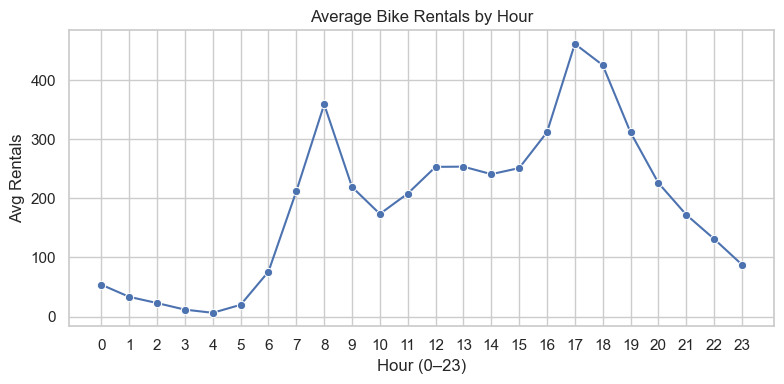

In [5]:
# 4a. Avg rentals by hour
hourly = df.groupby('hr', as_index=False)['rentals'].mean()
plt.figure(figsize=(8,4))
sns.lineplot(data=hourly, x='hr', y='rentals', marker='o')
plt.title('Average Bike Rentals by Hour')
plt.xlabel('Hour (0–23)')
plt.ylabel('Avg Rentals')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

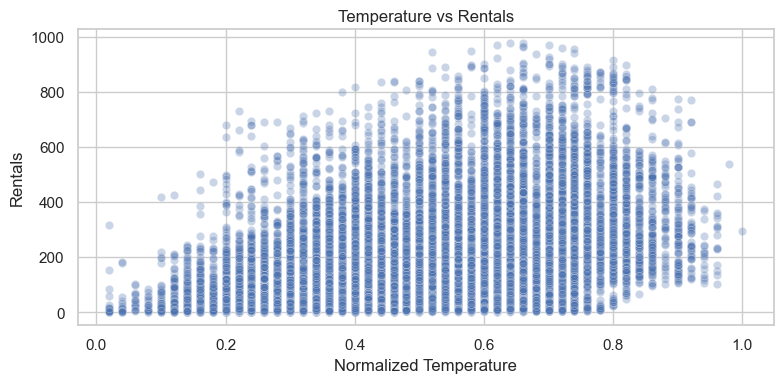

In [6]:
# 4b. Rentals vs temperature
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='temp', y='rentals', alpha=0.3)
plt.title('Temperature vs Rentals')
plt.xlabel('Normalized Temperature')
plt.ylabel('Rentals')
plt.tight_layout()
plt.show()

In [20]:
# 5. Feature engineering
# 5a. Categorical casts & dummies (only if present)
to_cast = [col for col in ['season', 'weathersit'] if col in df.columns]
for col in to_cast:
    df[col] = df[col].astype('category')
# apply one-hot encoding only for columns that exist
if to_cast:
    df = pd.get_dummies(df, columns=to_cast, drop_first=True)

# 5b. Cyclical hour
import numpy as np
if 'hr' in df.columns:
    df['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
    df['hr_cos'] = np.cos(2 * np.pi * df['hr'] / 24)


In [21]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

In [22]:
# 8. Baseline: Linear Regression
scaler_base = StandardScaler().fit(X_train.select_dtypes(include=[np.number]))
Xtr_scaled = scaler_base.transform(X_train.select_dtypes(include=[np.number]))
Xte_scaled = scaler_base.transform(X_test.select_dtypes(include=[np.number]))
lr = LinearRegression().fit(Xtr_scaled, y_train)
pred_lr = lr.predict(Xte_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)
print(f"Linear Regression → RMSE: {rmse_lr:.2f}, R²: {r2_lr:.3f}")

Linear Regression → RMSE: 126.86, R²: 0.492


In [23]:
# 9. Full pipeline + model comparison & tuning
# Feature lists
cat_feats = [c for c in X.columns if c.startswith('season_') or c.startswith('weathersit_')]
num_feats = [c for c in X.columns if c not in cat_feats]

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feats)
])

In [24]:
# Models to compare
models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(learning_rate=0.1, random_state=42)
}

for name, estimator in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', estimator)])
    cv_scores = -1 * GridSearchCV(
        pipe, {}, cv=5,
        scoring='neg_root_mean_squared_error'
    ).fit(X_train, y_train).cv_results_['mean_test_score']
    print(f"{name} CV RMSE: {cv_scores.mean():.2f}")

Ridge CV RMSE: 127.65
RandomForest CV RMSE: 43.89
GradientBoosting CV RMSE: 68.28


In [25]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None]
}
pipe_rf = Pipeline([('pre', preprocessor),
                    ('model', RandomForestRegressor(random_state=42))])
grid_rf = GridSearchCV(
    pipe_rf, param_grid, cv=5,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)
print("Best RF CV RMSE:", -grid_rf.best_score_)


Best RF params: {'model__max_depth': 20, 'model__n_estimators': 100}
Best RF CV RMSE: 43.75553851785158


In [26]:
# 10. Final evaluation on test set
pred_rf = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)
print(f"Random Forest Test → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

Random Forest Test → RMSE: 42.53, R²: 0.943


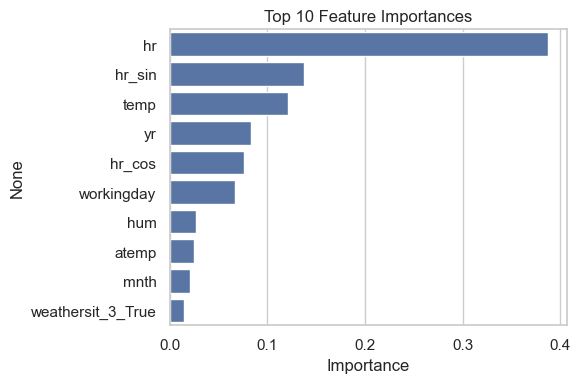

In [16]:
# 11. Feature importances
# Extract OHE feature names
cat_trans = best_rf.named_steps['pre'].named_transformers_['cat']
if hasattr(cat_trans, 'named_steps'):
    ohe = cat_trans.named_steps['onehot']
else:
    ohe = cat_trans
cat_names = ohe.get_feature_names_out(cat_feats)
feature_names = num_feats + list(cat_names)

importances = best_rf.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=feature_names).nlargest(10)

plt.figure(figsize=(6,4))
sns.barplot(x=fi.values, y=fi.index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
